In [3]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-whitegrid')
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [4]:
# Some functions to help out with
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [5]:
import os
fileList = os.listdir("")

In [6]:
kotaKabList = []
for file in fileList:
    kotaKabName = file.split("_")[0]
    if kotaKabName != "all":
        kotaKabList.append(kotaKabName)
print(kotaKabList)

['.config', 'Kota Surabaya.csv', 'sample']


In [7]:
# First, we get the data
# umkList = ["Kab. Gresik", "Kab. Sidoarjo", "Kota Surabaya"]
umkList = ["Kota Surabaya"]
df_ = {}
for i in umkList:
    df_[i] = pd.read_csv("/content/" + i + ".csv", index_col="Tahun", parse_dates=["Tahun"])

In [8]:
def split(dataframe, border, col):
    return dataframe.loc[:border,col], dataframe.loc[border:,col]

df_new = {}
for i in umkList:
    df_new[i] = {}
    df_new[i]["Train"], df_new[i]["Test"] = split(df_[i], "2020", "Umk")

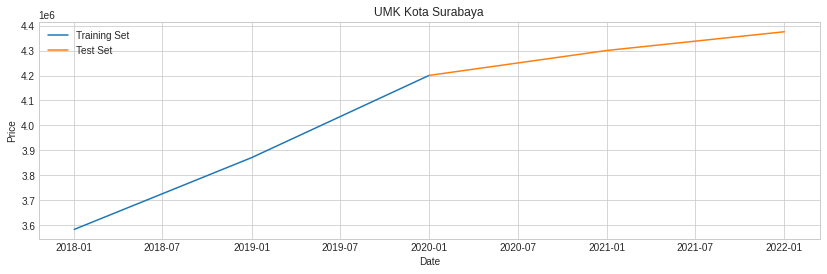

In [9]:
for i in umkList:
    plt.figure(figsize=(14,4))
    plt.plot(df_new[i]["Train"])
    plt.plot(df_new[i]["Test"])
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.title("UMK " + i)

In [10]:
# Scaling the training set
transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(umkList):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_new[i]["Train"])
    a1 = np.array(df_new[i]["Test"])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.fit_transform(a1)
    scaler[i] = sc
    
del a0
del a1

In [11]:
for i in transform_train.keys():
    print(i, transform_train[i].shape)
print("\n")    
for i in transform_test.keys():
    print(i, transform_test[i].shape)

Kota Surabaya (3, 1)


Kota Surabaya (3, 1)


In [12]:
trainset = {}
testset = {}
for j in umkList:
    trainset[j] = {}
    X_train = []
    y_train = []
    for i in range(1, 3):
        X_train.append(transform_train[j][i-1:i,0])
        y_train.append(transform_train[j][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset[j]["y"] = y_train
    
    testset[j] = {}
    X_test = []
    y_test = []    
    for i in range(1, 3):
        X_test.append(transform_test[j][i-1:i,0])
        y_test.append(transform_test[j][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test

In [13]:
arr_buff = []
for i in umkList:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=umkList)

,X_train,y_train,X_test,y_test
Kota Surabaya,"(2, 1, 1)","(2,)","(2, 1, 1)","(2,)"


In [14]:
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
# Fitting to the training set
for i in umkList:
    print("Fitting to", i)
    regressor.fit(trainset[i]["X"], trainset[i]["y"], epochs=5000, batch_size=2)

Streaming output truncated to the last 5000 lines.
Epoch 2502/5000
1/1 [==============================] - 0s 17ms/step - loss: 9.3292e-04
Epoch 2503/5000
1/1 [==============================] - 0s 21ms/step - loss: 0.0020
Epoch 2504/5000
1/1 [==============================] - 0s 21ms/step - loss: 0.0018
Epoch 2505/5000
1/1 [==============================] - 0s 17ms/step - loss: 0.0058
Epoch 2506/5000
1/1 [==============================] - 0s 23ms/step - loss: 0.0044
Epoch 2507/5000
1/1 [==============================] - 0s 22ms/step - loss: 0.0318
Epoch 2508/5000
1/1 [==============================] - 0s 23ms/step - loss: 0.0034
Epoch 2509/5000
1/1 [==============================] - 0s 27ms/step - loss: 0.0041
Epoch 2510/5000
1/1 [==============================] - 0s 26ms/step - loss: 0.0065
Epoch 2511/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0021
Epoch 2512/5000
1/1 [==============================] - 0s 21ms/step - loss: 0.0194
Epoch 2513/5000
1/1 [===========

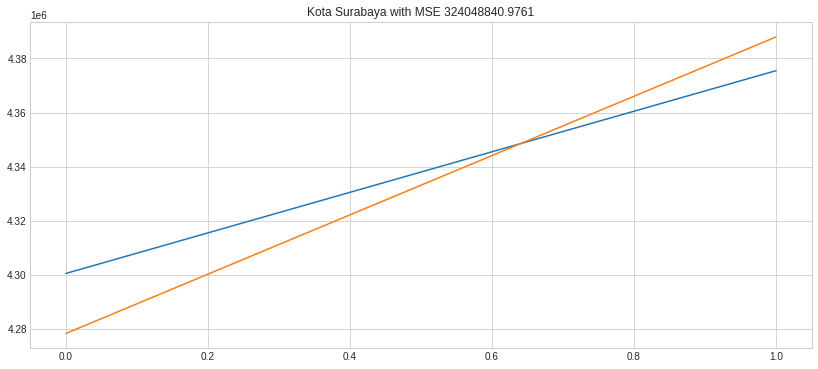

In [15]:
pred_result = {}
for i in umkList:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred
    plt.figure(figsize=(14,6))
    plt.title("{} with MSE {:10.4f}".format(i,MSE))
    plt.plot(y_true)
    plt.plot(y_pred)
    